In [1]:
import sys
import os

from datetime import datetime

import polars as pl
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "src"))
sys.path.append(src_path)
from utils import lift_metric_plot

import warnings

warnings.filterwarnings("ignore")

# Main info
* Our baseline solution will be based on Catboost with default parameters without selecting hyperparameters of the model

In [3]:
pl_data = pl.read_csv("/Users/kurmangazykarabekov/Desktop/собесы/12Go Asia/data.csv")

In [4]:
pl_data["isFraud"].to_pandas().value_counts(normalize=True)

isFraud
0    0.997741
1    0.002259
Name: proportion, dtype: float64

**Convert date**

In [5]:
pl_data = (
    pl_data.with_columns(
        pl.col("createdon")
        .str.strptime(
            pl.Datetime,
            format="%Y-%m-%d %H:%M:%S%z",
        )
        .cast(pl.Datetime("us", time_zone="UTC"))
    )
    .with_columns(
        pl.col("date_of_birth")
        .str.strptime(
            pl.Datetime,
            format="%Y-%m-%d",
        )
        .cast(pl.Datetime("us", time_zone="UTC"))
    )
    .with_columns(
        pl.col("godate")
        .str.strptime(
            pl.Datetime,
            format="%Y-%m-%d %H:%M:%S%z",
        )
        .cast(pl.Datetime("us", time_zone="UTC"))
    )
    .with_columns(
        pl.col("paidon")
        .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S.%f%z", strict=False)
        .cast(pl.Datetime("us", time_zone="UTC"))
    )
)

In [6]:
pl_data = pl_data.sort("createdon", descending=False)

In [7]:
pl_data = pl_data.with_columns(
    pl.col("channel").fill_null("unknown"),
    pl.col("cust_name").fill_null("unknown"),
    pl.col("nationality").fill_null("unknown"),
    pl.col("payer_country").fill_null("unknown"),
    pl.col("proxy").fill_null(0.0),
    pl.col("tor").fill_null(0.0),
    pl.col("vpn").fill_null(0.0),
    pl.col("recent_abuse").fill_null(0.0),
)

In [8]:
print(f"Min data of booking {pl_data['createdon'].min()}")
print(f"Max data of booking {pl_data['createdon'].max()}")

Min data of booking 2021-04-30 17:21:17+00:00
Max data of booking 2023-11-30 16:59:52+00:00


In [9]:
date_split_utc = pl.datetime(2023, 10, 26, 0, 0, 0).cast(
    pl.Datetime("us", time_zone="UTC")
)

In [10]:
pl_data.filter(pl.col("createdon") < date_split_utc)[
    "isFraud"
].to_pandas().value_counts(normalize=True)

isFraud
0    0.997745
1    0.002255
Name: proportion, dtype: float64

In [11]:
pl_data.filter(pl.col("createdon") >= date_split_utc)[
    "isFraud"
].to_pandas().value_counts(normalize=True)

isFraud
0    0.997713
1    0.002287
Name: proportion, dtype: float64

In [12]:
train_data = pl_data.filter(pl.col("createdon") < date_split_utc)
test_data = pl_data.filter(pl.col("createdon") >= date_split_utc)

In [13]:
X_train = train_data.drop(
    [
        "isFraud",
        "bid",
        "cust_name",
        "date_of_birth",
        "email",
        "godate",
        "ip",
        "paidon",
        "payer_name",
        "useragent",
        "usr_name",
        "createdon",]
).to_pandas()
y_train = train_data["isFraud"].to_pandas()

X_test = test_data.drop(
    [
        "isFraud",
        "bid",
        "cust_name",
        "date_of_birth",
        "email",
        "godate",
        "ip",
        "paidon",
        "payer_name",
        "useragent",
        "usr_name",
        "createdon",
    ]
).to_pandas()
y_test = test_data["isFraud"].to_pandas()

In [14]:
cat_features = ["channel", "nationality", "payer_country", "role_id", "vehclass_id"]

In [16]:
clf = CatBoostClassifier(
    iterations=1000,
    thread_count=-1,
    random_seed=42,
    cat_features=cat_features
    )

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=100,
    use_best_model=True,
    early_stopping_rounds=50,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.229368
0:	learn: 0.2111932	test: 0.1906107	best: 0.1906107 (0)	total: 3.65s	remaining: 1h 46s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.01461966396
bestIteration = 9

Shrink model to first 10 iterations.


In [28]:
clf._get_params()

{'random_seed': 42,
 'od_wait': 50,
 'od_type': 'Iter',
 'use_best_model': True,
 'verbose': 100,
 'loss_function': 'Logloss',
 'iterations': 1000,
 'cat_features': ['channel',
  'nationality',
  'payer_country',
  'role_id',
  'vehclass_id']}

In [26]:
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

In [18]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    441458
           1       0.00      0.00      0.00      1012

    accuracy                           1.00    442470
   macro avg       0.50      0.50      0.50    442470
weighted avg       1.00      1.00      1.00    442470



In [19]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


ROC-AUC Score: 0.7146


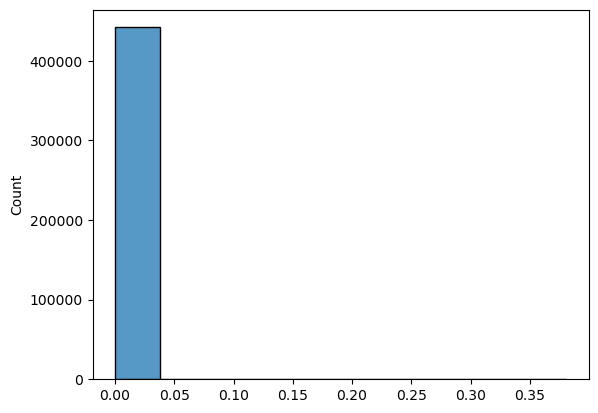

In [20]:
sns.histplot(y_pred_proba,bins=10)
plt.show()

In [21]:
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,email_score,37.569099
1,netprice_thb,13.915666
2,vpn,13.101580
3,p_attempts,7.957480
4,payer_country,6.483127
5,role_id,4.915473
6,insurance_flg,3.372299
7,seats,2.953080
8,vehclass_id,2.746553
9,nationality,1.998562


In [22]:
def lift_metric_plot(model, X_test, y_test):
    all_pred = pd.DataFrame()
    all_pred["prob"] = model.predict_proba(X_test)[:, 1]
    all_pred["true"] = y_test.values
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score

    y_true = all_pred["true"]
    recall = []
    precision = []
    score = []
    f_score = []

    aa = -np.sort(
        -all_pred["prob"].describe(percentiles=np.linspace(0, 1, 101))[4:105].values
    )
    for i in range(0, len(aa)):
        f = lambda x: 1 if x >= aa[i] else 0
        score.append(aa[i])
        y_pred = all_pred["prob"].map(f)
        g = recall_score(y_true, y_pred, average="binary")
        recall.append(g)
        p = precision_score(y_true, y_pred, average="binary")
        precision.append(p)
        t = f1_score(y_true, y_pred, average="binary")
        f_score.append(t)

    temp = pd.DataFrame()
    temp["score"] = score
    temp["recall"] = recall
    temp["precision"] = precision
    temp["top_percentile"] = np.round(list(np.linspace(0, 100, 101))).tolist()

    temp["lift"] = temp["recall"] / (temp["top_percentile"] / 100.0)
    temp["max_lift"] = 1 / (y_test.sum() / len(y_test))
    temp["relative_lift"] = temp["lift"] / temp["max_lift"]

    temp["percent"] = 100 * (y_test.sum() / len(y_test))
    plt.figure()
    plt.plot(temp[1:]["top_percentile"], temp[1:]["lift"])
    plt.xlabel("Percentile")
    plt.ylabel("LIFT")
    plt.scatter(
        1,
        temp[temp["top_percentile"] == 1]["lift"][1],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        1,
        temp[temp["top_percentile"] == 1]["lift"][1],
        "      top 1 : {}".format(
            np.round(temp[temp["top_percentile"] == 1]["lift"][1], 3)
        ),
        fontsize=10,
    )
    plt.scatter(
        10,
        temp[temp["top_percentile"] == 10]["lift"][10],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        10,
        temp[temp["top_percentile"] == 10]["lift"][10],
        "      top 10 : {}".format(
            np.round(temp[temp["top_percentile"] == 10]["lift"][10], 3)
        ),
        fontsize=10,
    )
    plt.title("Lift-chart")
    plt.figure()
    plt.plot(temp[1:]["top_percentile"], temp[1:]["relative_lift"])
    plt.xlabel("Percentile")
    plt.ylabel("Relative_lift")
    plt.scatter(
        1,
        temp[temp["top_percentile"] == 1]["relative_lift"][1],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        1,
        temp[temp["top_percentile"] == 1]["relative_lift"][1],
        "      top 1 : {}".format(
            np.round(temp[temp["top_percentile"] == 1]["relative_lift"][1], 3)
        ),
        fontsize=10,
    )
    plt.scatter(
        10,
        temp[temp["top_percentile"] == 10]["relative_lift"][10],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        10,
        temp[temp["top_percentile"] == 10]["relative_lift"][10],
        "      top 10 : {}".format(
            np.round(temp[temp["top_percentile"] == 10]["relative_lift"][10], 3)
        ),
        fontsize=10,
    )
    plt.title("Relative-lift-chart")
    plt.figure()
    plt.plot(temp[1:]["top_percentile"], temp[1:]["recall"])
    plt.xlabel("Percentile")
    plt.ylabel("GAIN")
    plt.scatter(
        10,
        temp[temp["top_percentile"] == 10]["recall"][10],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        10,
        temp[temp["top_percentile"] == 10]["recall"][10],
        "      top 10 : {}".format(
            np.round(temp[temp["top_percentile"] == 10]["recall"][10], 3)
        ),
        fontsize=10,
    )
    plt.scatter(
        40,
        temp[temp["top_percentile"] == 40]["recall"][40],
        marker="o",
        s=30,
        zorder=10,
        color="b",
    )
    plt.text(
        40,
        temp[temp["top_percentile"] == 40]["recall"][40],
        "      top 40 : {}".format(
            np.round(temp[temp["top_percentile"] == 40]["recall"][40], 3)
        ),
        fontsize=10,
    )
    plt.title("Gain-chart")
    from sklearn.metrics import roc_curve, auc

    fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(
        fpr, tpr, color="darkorange", lw=1, label="ROC curve (area = %0.2f)" % roc_auc
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()
    print(temp[1:].head(10))
    return temp[1:]

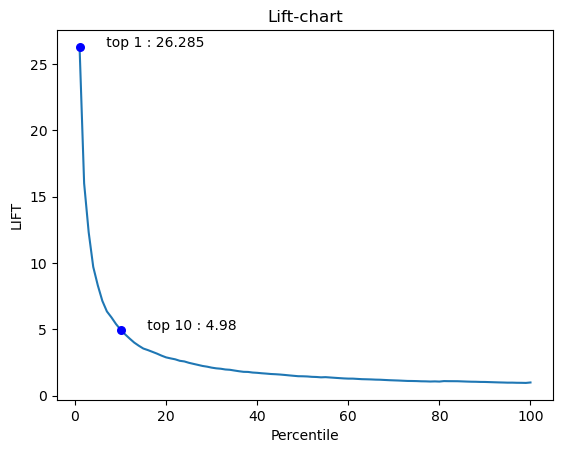

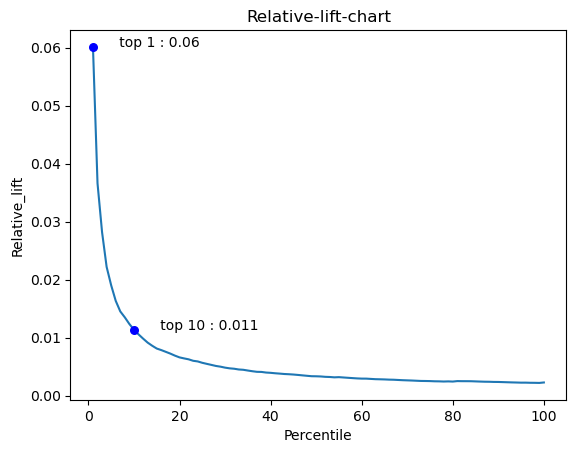

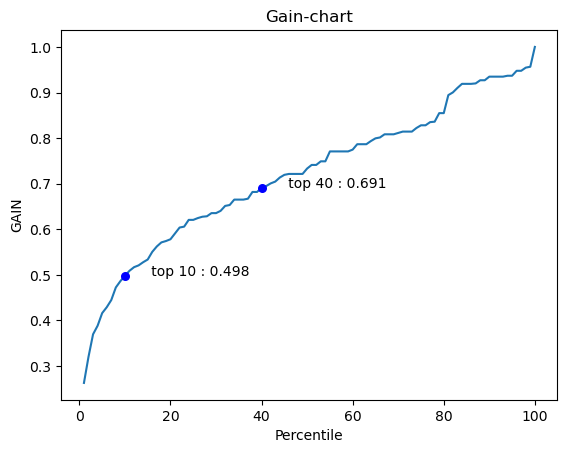

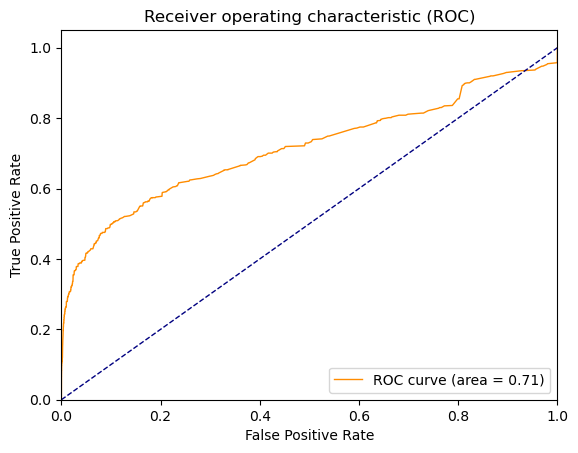

       score    recall  precision  top_percentile       lift   max_lift  \
1   0.005273  0.262846   0.059910             1.0  26.284585  437.22332   
2   0.003598  0.320158   0.036594             2.0  16.007905  437.22332   
3   0.003231  0.369565   0.027875             3.0  12.318841  437.22332   
4   0.002923  0.388340   0.022195             4.0   9.708498  437.22332   
5   0.002723  0.416008   0.018941             5.0   8.320158  437.22332   
6   0.002615  0.428854   0.016327             6.0   7.147563  437.22332   
7   0.002410  0.444664   0.014508             7.0   6.352343  437.22332   
8   0.002210  0.472332   0.013444             8.0   5.904150  437.22332   
9   0.002122  0.486166   0.012310             9.0   5.401845  437.22332   
10  0.002025  0.498024   0.011262            10.0   4.980237  437.22332   

    relative_lift   percent  
1        0.060117  0.228716  
2        0.036613  0.228716  
3        0.028175  0.228716  
4        0.022205  0.228716  
5        0.019030  0.228

,score,recall,precision,top_percentile,lift,max_lift,relative_lift,percent
1,0.005273,0.262846,0.059910,1.0,26.284585,437.22332,0.060117,0.228716
2,0.003598,0.320158,0.036594,2.0,16.007905,437.22332,0.036613,0.228716
3,0.003231,0.369565,0.027875,3.0,12.318841,437.22332,0.028175,0.228716
4,0.002923,0.388340,0.022195,4.0,9.708498,437.22332,0.022205,0.228716
5,0.002723,0.416008,0.018941,5.0,8.320158,437.22332,0.019030,0.228716
...,...,...,...,...,...,...,...,...
96,0.000964,0.947628,0.002238,96.0,0.987113,437.22332,0.002258,0.228716
97,0.000949,0.947628,0.002233,97.0,0.976937,437.22332,0.002234,0.228716
98,0.000931,0.954545,0.002228,98.0,0.974026,437.22332,0.002228,0.228716
99,0.000928,0.956522,0.002205,99.0,0.966184,437.22332,0.002210,0.228716


In [23]:
lift_metric_plot(clf, X_test, y_test)

## Analysis of the results of the basic Isolation Forest model

###1. Classification metrics:
- **Accuracy**: 1.00 - high overall accuracy, but this is due to class imbalance
- **Precision for Class 0**: 1.00 (normal transactions)
- **Precision for Class 1**: 0.00 (fraudulent transactions)
- **Recall for Class 1**: 0.00 - the model did not detect any fraudulent transactions
- **F1-score for Class 1**: 0.00

### 2. ROC-AUC analysis:
- ROC-AUC score: 0.71
- The ROC curve is above the random classifier (diagonal line)
- Shows a moderate ability of the model to distinguish classes
- There is a potential for improvement, as the value is not very high

### 3. Threshold Analysis (Top Percentages):
- At a threshold of 1%:
* Recall: 0.262
* Precision: 0.059
* Lift: 26.28
- At a threshold of 5%:
* Recall: 0.416
* Precision: 0.019
* Lift: 8.32

### Conclusions:
1. **Problems of the model**:
- The model is strongly biased towards the majority class
- Zero recall for fraudulent transactions
- Requires significant refinement

2. **Areas of improvement**:
- Balancing of classes is necessary
- The contamination parameter needs to be configured
- It is possible to add feature engineering
- Consider other algorithms or ensembles

3. **Positive aspects**:
- ROC-AUC 0.71 shows that the model has potential
- A high lift in the upper percentiles indicates the model's ability to rank transactions by risk